# Survival Regression Analysis on Customer Churn

In this post, we will analyze [Telcon's Customer Churn Dataset](https://www.kaggle.com/blastchar/telco-customer-churn) and figure out what factors contribute to churn. By definition, a customer churns when they unsubscribe or leaves a service. With survival analysis, the customer churn event is analogous to "death". Armed with the survival function, we will calculate what is the optimum monthly rate to maximize a customers lifetime value. The source of this post and instructions to reproduce this analysis can be found at the [thomasjpfan/ml-journal repo](https://github.com/thomasjpfan/ml-journal/tree/master/notebooks/telcom-customer-churn). 

In [1]:
# <!-- collapse=None -->
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from lifelines.plotting import plot_lifetimes

In [2]:
# <!-- collapse=None -->
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['lines.linewidth'] = 2.5

def add_title(ax, title, subtitle, x):
    y_min, y_max = ax.get_ylim()
    y_title = (y_max - y_min)*0.085 + y_max
    y_subtitle = (y_max - y_min)*0.025 + y_max
    ax.text(x, y_subtitle, subtitle, fontsize=19, alpha=.75)
    ax.text(x, y_title, title, fontsize=26, alpha=.85, weight='bold')
    return ax
    
def config_ticks(ax):
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    return ax
    
def add_title_fig(fig, title, subtitle, x, y_title, y_subtitle):
    fig.text(x, y_title, title, fontweight='bold', fontsize=26, alpha=.85)
    fig.text(x, y_subtitle, subtitle,  fontsize=19, alpha=.75)
    return fig

def add_yaxis(ax, y=0):
    return ax.axhline(y=y, color='black', linewidth=1.3, alpha=0.7)

def convert_cat(df):
    df = df.copy()
    
    internet_dict = {'No': 0, 'Yes': 1, 'No internet service': 0}
        
    out = df.assign(
        Partner=df.Partner == 'Yes',
        MultipleLines=df.MultipleLines.map({'No': 0, 'Yes': 1, 'No phone service': 0}),
        InternetService=df.InternetService.map({'Fiber optic': 1, 'DSL': 1, 'No': 0}),
        OnlineSecurity=df.OnlineSecurity.map(internet_dict),
        OnlineBackup=df.OnlineBackup.map(internet_dict),
        DeviceProtection=df.DeviceProtection.map(internet_dict),
        TechSupport=df.TechSupport.map(internet_dict),
        StreamingTV=df.StreamingTV.map(internet_dict), 
        StreamingMovies=df.StreamingMovies.map(internet_dict),
        Contract=df.Contract.map({'Month-to-month': 1, 'One year': 12, 'Two year': 24}),
        PaperlessBilling=df.PaperlessBilling == 'Yes' ,
        automatic_payment=df.PaymentMethod.str.contains("automatic"),
        Churn=df.Churn == 'Yes'
    ).drop(columns=['gender', 'PaymentMethod', 'customerID', 'TotalCharges', 'SeniorCitizen', 'Dependents', 'PhoneService'])
    
    return out

def plot_boolean_covariate(fitter, name, ax=None):
    ax = fitter.plot_partial_effects_on_outcome(name, [0, 1], ax=ax, plot_baseline=False)
    _ = ax.set_ylabel("Survival Function")
    _ = ax.set_xlabel("Time (months)")
    _ = ax.set_xlim((-1, 73))
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_color('red')
    handles[1].set_color('green')
    handles[0], handles[1] = handles[1], handles[0]
    ax.legend(handles, ['True', 'False'])
    return ax

def get_expected_value(fitter, monthly_charges, events):
    X = events.mean().to_frame().T
    output = np.empty_like(monthly_charges, dtype=np.float32)
    for i, mc in enumerate(monthly_charges):
        X['MonthlyCharges'] = mc
        output[i] = mc*fitter.predict_expectation(X)
    return output

## Overview of the dataset

The dataset consist of many featuers associated with a customer. For regular survivial analysis, we only need the `tenure` and `Churn` features. The `tenure` is the number of time a customer has stayed with the service. The boolean `Churn` feature states if the customer churned or not:

In [3]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df[['tenure', 'Churn']].head()

,tenure,Churn
0,1,No
1,34,No
2,2,Yes
3,45,No
4,2,Yes


For customers that did not churn yet, they may churn in the future. Since this is data from the future, it is not recorded in our dataset. Datasets exhibiting this behavior are called **right-censored**. Luckily the Cox's model is able to handle right-censored data.

## Loading data and fitting the model

We use the [lifelines](https://lifelines.readthedocs.io/en/latest/index.html) project to train a Cox’s Proportional Hazard model. This model is able to do regression on the other featuers in the dataset.

In [4]:
from lifelines import CoxPHFitter

events = convert_cat(df)
cph = CoxPHFitter()
_ = cph.fit(events, duration_col='tenure', event_col='Churn')

With the fitted survivial regression model, we take a look at how each feature affects the survivial function:

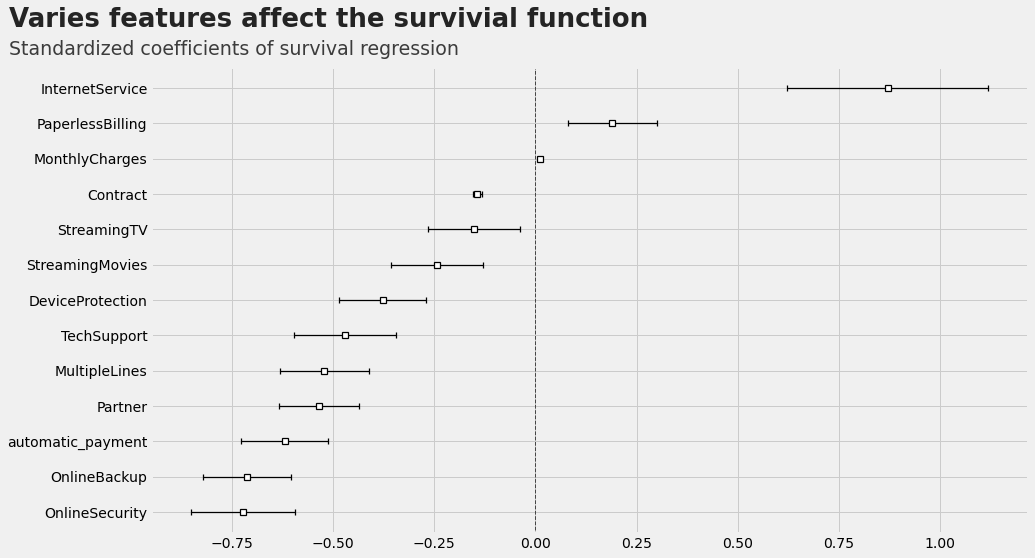

In [5]:
# <!-- collapse=None -->
ax = cph.plot()
ax = add_title(ax, "Varies features affect the survivial function", 
               "Standardized coefficients of survival regression", -1.3)
_ = ax.set_xlabel("")

The standardized cofficients gives a sense of the impact of each feature. The closer the cofficient is to zero, the less effect it has on the survivial function. The survivial function defines the probability the churn event has not occured yet at a given month, $t$:
$$
S(t) = P(T > t)
$$
For example, when $t=0$, the probabilty $P(T > 0) = 1$, because on an infinite time scale, a customer will always churn. The boolean `automatic_payment` feature denotes if a customer has automatic payments enabled. We plot the survivial function with or without automatic payments:

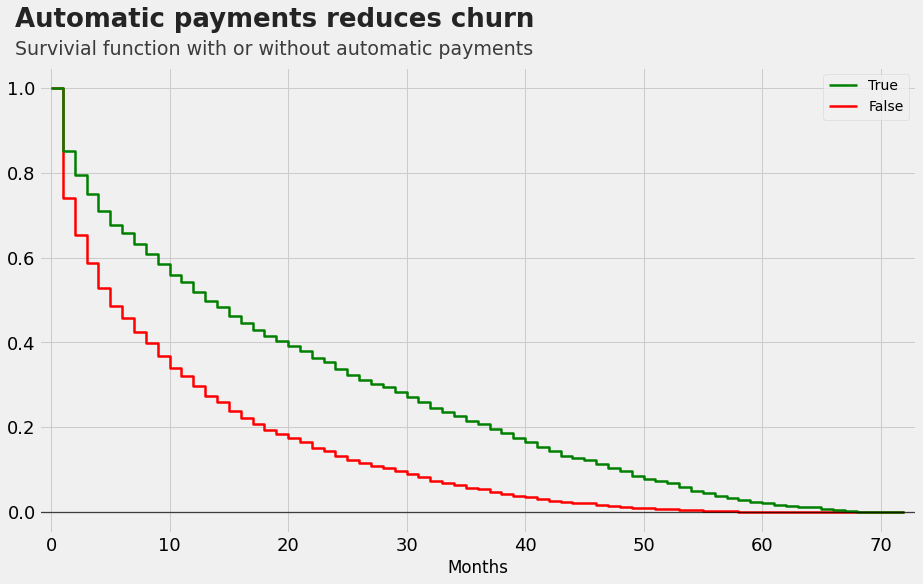

In [6]:
# <!-- collapse=None -->
ax = plot_boolean_covariate(cph, "automatic_payment")
ax.set_xlabel("Months")
ax.set_ylabel("")
ax = add_title(ax, "Automatic payments reduces churn",
               "Survivial function with or without automatic payments", -3)
_ = config_ticks(ax)
_ = add_yaxis(ax)

The green and red curve represents the survivial function when automatic payment is on or off respectively. The result is expected, the green curve is always above the red curve, i.e. enabling automatic payments increaese the probability of survivial. The other boolean features also help with customer churn: 

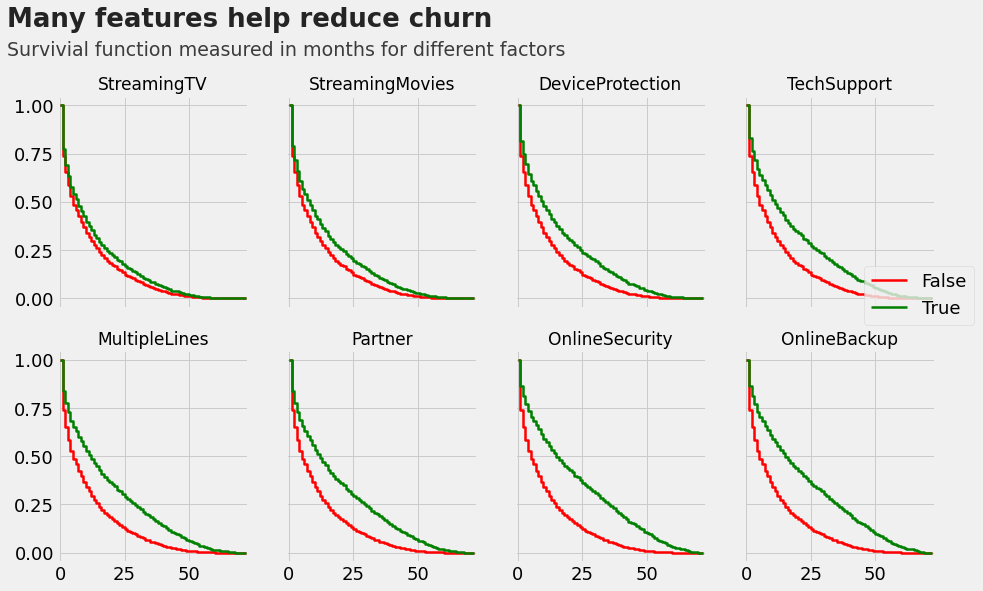

In [7]:
# <!-- collapse=None -->
center_names = [
    "StreamingTV", "StreamingMovies", "DeviceProtection", "TechSupport", 
    "MultipleLines", "Partner", "OnlineSecurity", "OnlineBackup"
]
fig, axes = plt.subplots(2, 4, sharey=True, sharex=True)
for name, ax in zip(center_names, axes.flatten()):
    ax = plot_boolean_covariate(cph, name, ax=ax)
    ax.set_title(name, fontdict={'size': 17})
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.legend_.remove()
    _ = config_ticks(ax)
    
fig.text(0.03, 1, "Many features help reduce churn", fontweight='bold', fontsize=26, alpha=.85)
fig.text(0.03, 0.95, "Survivial function measured in months for different factors",  fontsize=19, alpha=.75)
_ = fig.legend(labels=('False', 'True'), loc="center right", fancybox=True, fontsize=18)

The survivial function for various contract lengths shows the expected result, i.e. longer contracts prevents customers from leaving:

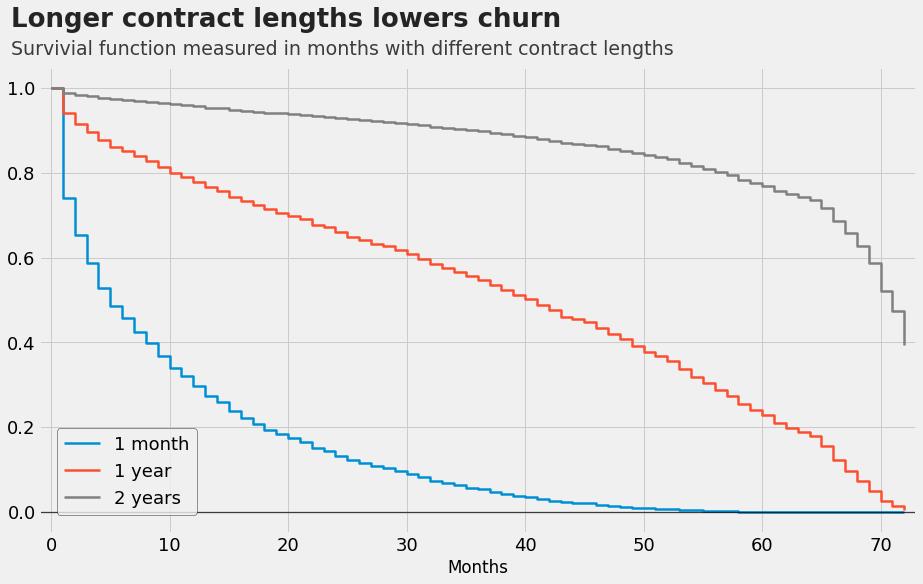

In [8]:
# <!-- collapse=None -->
contract_lengths = [1, 12, 24]
ax = cph.plot_partial_effects_on_outcome('Contract', contract_lengths, plot_baseline=False)
_ = ax.set_xlim((-1, 73))
_ = ax.set_xlabel("Months")
_ = add_yaxis(ax)
handles, labels = ax.get_legend_handles_labels()
handles[-1].set_color('gray')
_ = add_title(ax, "Longer contract lengths lowers churn", "Survivial function measured in months with different contract lengths", -3.4)
_ = ax.legend(handles, ['1 month', '1 year', '2 years'], edgecolor='black', loc=(0.02, 0.04), 
              fontsize=18)
_ = config_ticks(ax)

## Deep dive into monthly rates

In this section, we will calculate how much to charge a customer to maximize lifetime value. First, we visualize the monthly rate distrubution:

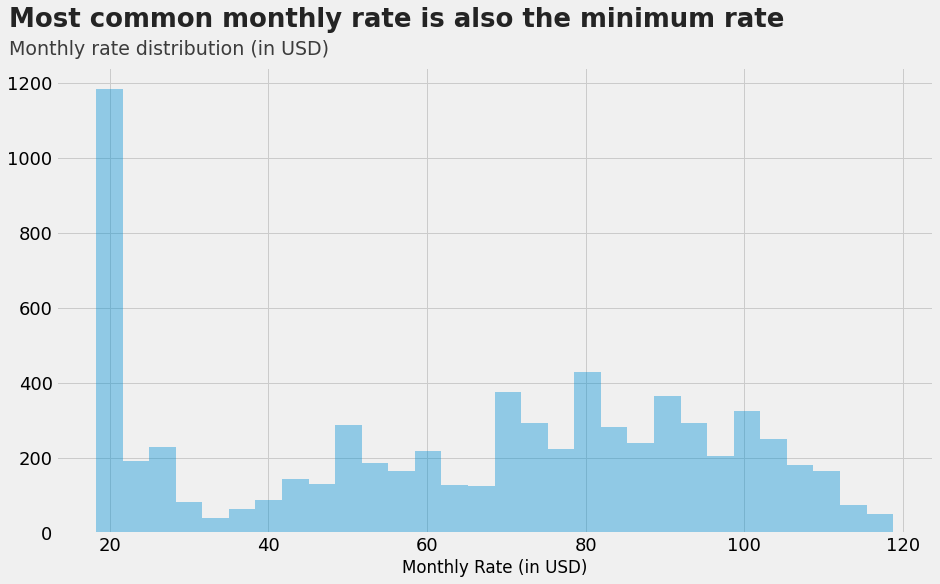

In [9]:
# <!-- collapse=None -->
ax = sns.distplot(df.MonthlyCharges, bins=30, kde=False)
ax.set_xlabel("Monthly Rate (in USD)")
add_title(ax, "Most common monthly rate is also the minimum rate", "Monthly rate distribution (in USD)", 7.3)
_ = add_yaxis(ax)
_ = config_ticks(ax)

Next, we plot the survivial function for different monthly rates:

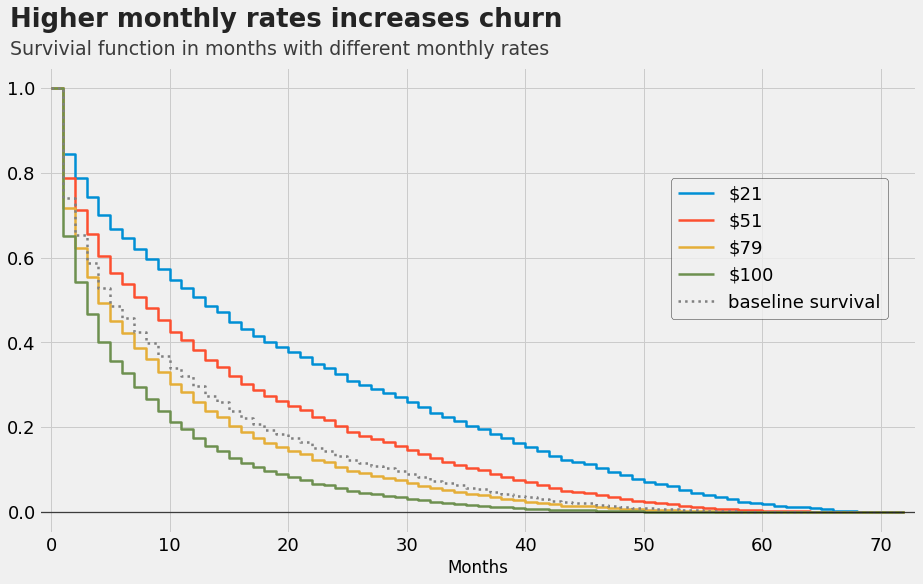

In [10]:
# <!-- collapse=None -->
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=4)
gm.fit(df[['MonthlyCharges']])
monthly_means = sorted(gm.means_[:,0].tolist())

ax = cph.plot_partial_effects_on_outcome('MonthlyCharges', monthly_means)
_ = ax.set_xlabel("Months")
_ = ax.set_xlim((-1, 73))
add_title(ax, "Higher monthly rates increases churn", 
          "Survivial function in months with different monthly rates", -3.5)
handles, labels = ax.get_legend_handles_labels()
handles[-1].set_color('gray')

_ = add_yaxis(ax)
_ = config_ticks(ax)
_ = ax.legend(handles, [f"${v:.0f}" for v in monthly_means]+ ['baseline survival'], loc=(0.72, 0.46), 
              edgecolor='black', fontsize=18)

Again the result is expected, the higher the monthly rate, the lower the survivial function. With these survivial functions, we can calculate the average number of months a customer will stay for different monthly rate. Multiplying the average number of months with the monthly rate, gives the lifetime value of a customer at each price point:

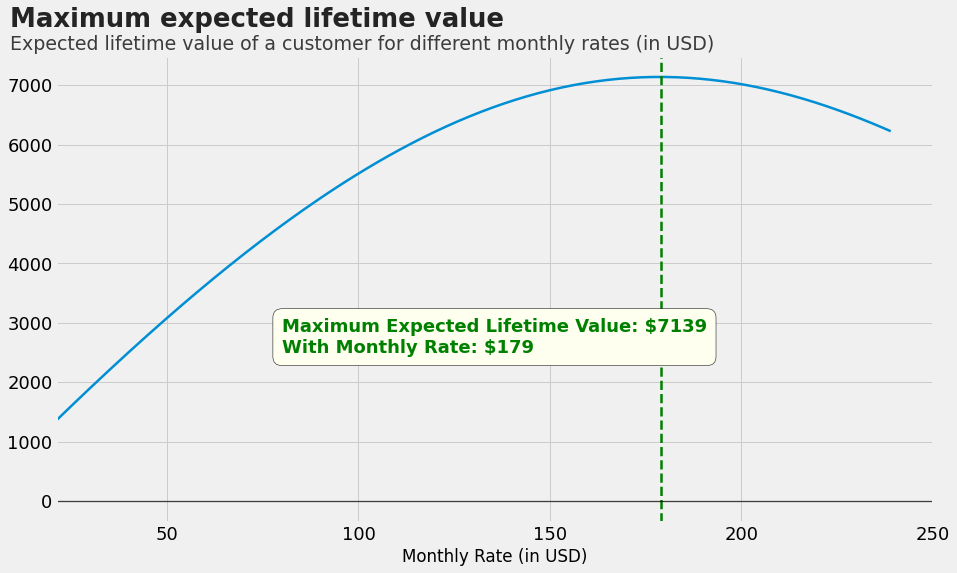

In [11]:
# <!-- collapse=None -->
monthly_charges = np.arange(20, 240) 
lifetime_value = get_expected_value(cph, monthly_charges, events)
lifetime_max_arg = np.argmax(lifetime_value)
lifetime_max = np.max(lifetime_value)
monthly_charge_max = monthly_charges[lifetime_max_arg]
fig, ax = plt.subplots()
ax.plot(monthly_charges, lifetime_value)
ax.axvline(x=monthly_charge_max, c='green', ls='dashed')
ax.set_xlabel("Monthly Rate (in USD)")
ax.text(80, 2500, f'Maximum Expected Lifetime Value: ${lifetime_max:.0f}\nWith Monthly Rate: ${monthly_charge_max:.0f}', color='green', 
        bbox=dict(facecolor='ivory', edgecolor='black', boxstyle='round,pad=0.5'), fontdict={'size': 18, 'weight': "bold"})
ax.set_xlim((21, 250))
add_title(ax,'Maximum expected lifetime value', 'Expected lifetime value of a customer for different monthly rates (in USD)', 9)
_ = config_ticks(ax)
_ = add_yaxis(ax)

In this case, the maximum expected lifetime value is 7139 USD, using a monthly rate of 179 USD.

## Whats next?

Survival analysis is a powerful way to look at customer churn data. We calculated the impact of each feature on the survivial curve. Moreover, we used the survival curve to calculate the expected lifetime value of a customer for various monthly rates. The next step is to do the same analysis in a bayesian point of view, which adds a measure of uncertainty into the model, enhancing our understanding of the underlying processes.